# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
3. Pick the distribution you want to try by changing it from markdown to code
2. Click on the restart and run kernel icon for ipython


In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt

**Initialize Variables**

The following variables determine how the simulation will perform. Each variable has a comment beside it describing what it means. We suggest you change individual variables one at a time and run the simulation each time to see how they impact the simulation.

In [2]:
#Glossary: https://github.com/keep-network/keep-core/blob/master/docs/glossary.adoc

# Group & Signature Parameters
group_size = 100 # number of virtual stakers in a group - nodes to stakers is a 1-many relationship
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 40 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
max_malicious_threshold = 0.25 # % of malicious node ownership needed to sign (used to determine lynchpin) = BLS_Signature Threshold
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 14 # number of steps after which a group expires

#Misbehaving_nodes = 25 # percent of nodes misbehaving during dkg
dkg_block_delay = 14 # blocks needed to run DKG
failed_signature_threshold = (group_size-(max_malicious_threshold * group_size +1))/group_size
# % of offline nodes causing a signature to fail
min_stake_amount = 100 # min amount required to stake a node
self_operator_mode = 1 # options[1,2]: 1- Nodes = Total Stake/Min Stake; 2- Nodes = 1 per owner

#Node parameters
node_failure_percent = 10 # % of nodes fail and have to reconnect
node_death_percent = 5 # % of time nodes fail and do not reconnect
node_connection_delay = 5 # max delay for a node to connect or reconnect after failure
node_mainloop_connection_delay = 3 # max delay for a node to fork or refork mainloop after failure

#operator parameters
malicious_operator_percent = 0.3
number_of_owners = 100

#Model Parameters
log_filename = 'master_sim.log'
run_number = 0
steps = 1000 #blocks

**Creating the virtual staker distributions**

The code below assignes virtual stakers to each node based on the specified distribution provided by an excel file. The values are converted to int. 

1. *Current Keep distribution*

The excel file here contains data on current keep staker distributions. The values are also proportional reduced by a factor of 10000 to reduce computation time.

distribution_data = pd.read_csv('token_distribution.csv')
stake_distribution = []
for value in distribution_data.values.tolist():
    if value[0] != "#NAME?":
        if float(value[0]) > 0 :
            stake_distribution.append(int(float(value[0])/10000))

nodes = len(stake_distribution)
stake_distribution.sort()
x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, stake_distribution)
plt.title("Virtual Staker Distribution")

2. **Linear distribution**

A standard linear distribution. This distribution is probably more decentralized than the Keep or Eth distributions

Text(0.5, 1.0, 'Virtual Staker Distribution')

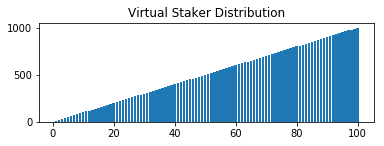

In [3]:
stake_distribution = np.zeros(number_of_owners) 

for i in range (0, number_of_owners):
    stake_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,number_of_owners,number_of_owners)
plt.subplot(2, 1, 1)
plt.bar(x, stake_distribution)
plt.title("Virtual Staker Distribution")


3. **Eth Distribution**

Top 32% of eth account holders by ownership percent. This is currently the default that the sim starts with

distribution_data = pd.read_csv('eth_distr.csv')
stake_distribution = []
val = ''
for value in distribution_data.values.tolist():
    val = float(value[0].strip('%'))
    stake_distribution.append(val*1000)
        
nodes = len(stake_distribution)
stake_distribution.sort()
x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, stake_distribution)
plt.title("Virtual Staker Distribution")

**Initialize the model**

Intializing the model and agents

In [4]:
beacon_model = model.Beacon_Model(stake_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  max_malicious_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay,
                                  min_nodes,
                                  node_connection_delay,
                                  node_mainloop_connection_delay,
                                  log_filename,
                                  run_number,
                                  dkg_block_delay,
                                  failed_signature_threshold,
                                  min_stake_amount,
                                  self_operator_mode,
                                  malicious_operator_percent
                                 )


creating nodes


**Stepping throgh the model**

The model steps through and changes the state of each agent at each step. The MESA data collector collects data on agent and model state at each step.

In [5]:
import time

active_group_size = []
signature_failures = []
start_time = time.time()
for i in range (steps):
    beacon_model.step()
print("--- %s seconds ---" % (time.time() - start_time))


model_data = beacon_model.datacollector.get_model_vars_dataframe() 
agent_data = beacon_model.datacollector.get_agent_vars_dataframe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--- 26.003469228744507 seconds ---


**Number of Active Groups**

The plot below shows a histogram of the number of active groups available at each step. Active groups increase due to the registration of new groups, which occurs when a relay entry is requested. Active groups remain active for the number of steps set by the group_expiry parameter. 

Text(0, 0.5, 'frequency')

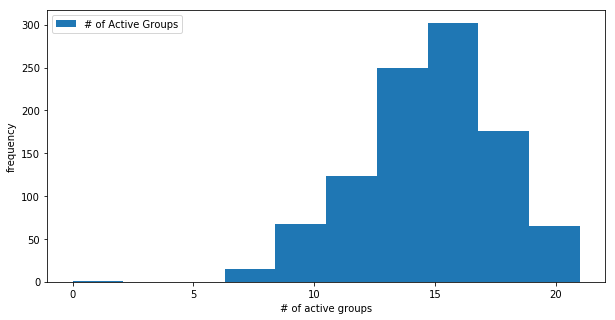

In [6]:
model_data.plot(kind='hist', legend = True, y = ['# of Active Groups'], figsize = (10,5))
plt.xlabel("# of active groups")
plt.ylabel("frequency")

**Active Groups, Node, and Signatures**

Active Groups: Active groups available at every step. Same as above active groups are created when a relay entry occurs and a group is successfully registered

Active Nodes: Active nodes are nodes in the staked status. This is based on the node state diagram provided by Antonio

Number of Signatures: Signatures completed in aggregate including those considered to have failed based on the number of offline nodes.

<function matplotlib.pyplot.show(*args, **kw)>

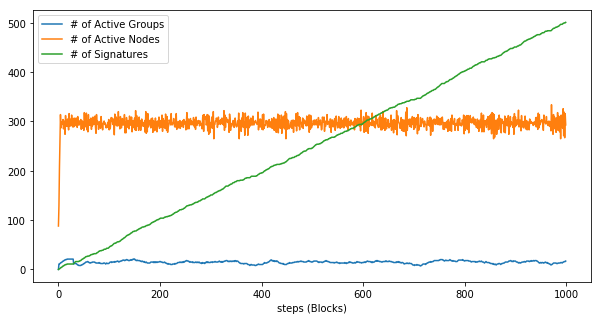

In [7]:
model_data.plot(kind='line', legend = True, y = ['# of Active Groups', '# of Active Nodes', '# of Signatures' ], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


**Median Malicious, Lynchpin, & Failure %**

Median Malicious Group % : We take the poppulation of groups and calculate median malicious ownership of the groups from the malicious % property of the group agent. The malicious ownership % is the percentage of the groups virtual stakers owned by malicious nodes.

Median Lynchpin Group % : Similar to above we take the Lynchpin % property of each group and find the median at each step. The Lynchpin % = %owned by 1 node + Offline nodes

Median Failure % : Signature failures are determined by the offline % evaluated against the failed signature threshold set above. Signatures with % of nodes offline > than the threshold are considered to have failed. Once again we calculate the median at each step.

<function matplotlib.pyplot.show(*args, **kw)>

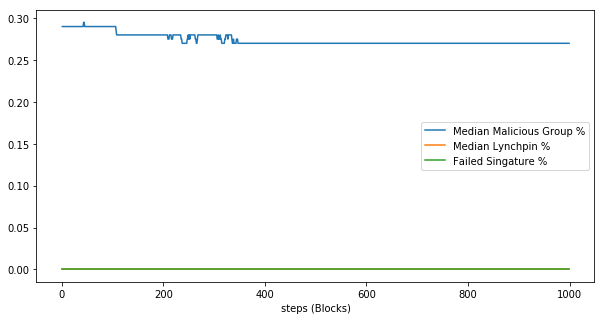

In [8]:
model_data.plot(kind='line', legend = True, y = ['Median Malicious Group %','Median Lynchpin %', 'Failed Singature %'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show

**Compromised Groups & Dominated Signatures**

% Compromised Groups: % of total groups designated as compromised based on the compromised threshold set above

% Dominated signatures: % of signatures desiganted as dominated based on the max malicious threshold set above

<function matplotlib.pyplot.show(*args, **kw)>

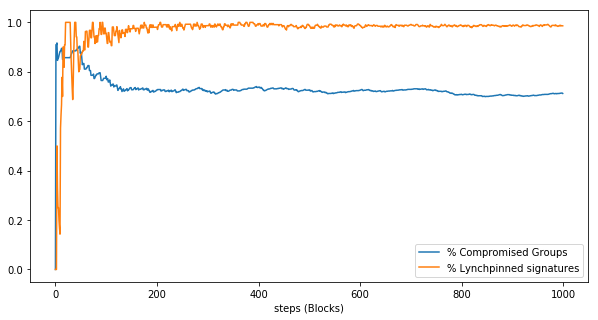

In [9]:
model_data.plot(kind='line', legend = True, y = ['% Compromised Groups','% Lynchpinned signatures'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


In [10]:

data = agent_data[(agent_data['Type']=='node')]# & (agent_data['Step']==400) ]
np.shape(agent_data)
data.loc[100]

#data['Ownership Distribution'][3]


,ID,Type,Node Status (Connection_Mainloop_Stake),Status,Malicious,DKG Block Delay,Ownership Distribution,Malicious %,Offline %,Lynchpin %,Owner
AgentID,,,,,,,,,,,
0,0,node,connected,None,True,NaN,None,NaN,NaN,NaN,9.0
1,1,node,connected,None,False,NaN,None,NaN,NaN,NaN,10.0
2,2,node,not connected,None,False,NaN,None,NaN,NaN,NaN,11.0
3,3,node,connected,None,False,NaN,None,NaN,NaN,NaN,12.0
4,4,node,connected,None,False,NaN,None,NaN,NaN,NaN,13.0
5,5,node,connected,None,False,NaN,None,NaN,NaN,NaN,14.0
6,6,node,connected,None,False,NaN,None,NaN,NaN,NaN,15.0
7,7,node,connected,None,False,NaN,None,NaN,NaN,NaN,16.0
8,8,node,connected,None,False,NaN,None,NaN,NaN,NaN,17.0


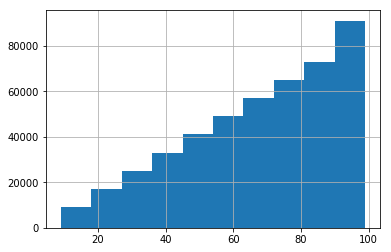

In [11]:
data.loc[:,'Owner'].hist()

In [12]:
{i : np.random.randint(100)<30 for i in range(20)}

{0: False,
 1: False,
 2: False,
 3: False,
 4: False,
 5: True,
 6: True,
 7: False,
 8: False,
 9: False,
 10: False,
 11: False,
 12: False,
 13: True,
 14: False,
 15: True,
 16: False,
 17: False,
 18: True,
 19: False}

In [13]:
model_data.loc[50:]

,# of Active Groups,# of Active Nodes,# of Signatures,Median Malicious Group %,% Compromised Groups,Median Lynchpin %,% Lynchpinned signatures,Failed Singature %
50,12,282,23,0.29,0.878788,0.0,0.869565,0.0
51,12,318,23,0.29,0.878788,0.0,0.869565,0.0
52,13,294,24,0.29,0.852941,0.0,0.875000,0.0
53,14,303,25,0.29,0.828571,0.0,0.880000,0.0
54,15,289,26,0.29,0.833333,0.0,0.884615,0.0
55,15,317,26,0.29,0.833333,0.0,0.884615,0.0
56,15,283,26,0.29,0.833333,0.0,0.923077,0.0
57,16,300,27,0.29,0.810811,0.0,0.888889,0.0
58,16,279,27,0.29,0.810811,0.0,0.888889,0.0
59,15,314,27,0.29,0.810811,0.0,0.962963,0.0
